In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from modules.metrics import rmse
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as fm

import tensorflow as tf
from tensorflow.keras import backend as K

jheng_hei_b_font = fm.FontProperties(fname=r'..\fonts\微軟正黑體_粗體.ttc')
jheng_hei_font = fm.FontProperties(fname=r'..\fonts\微軟正黑體_標準.ttc')

In [64]:
FEATURE_COLUMNS = ['Latitude', 'Longitude', 'VIL', 'MaxdBZ', 'CellVolume', 'UMotion', 'VMotion']  # 欄位名稱
LATITUDE = 'Latitude'
LONGITUDE = 'Longitude'
WINDOW_SIZE = 2
STEPS_SIZE = 1
# CELL_DATASET_PATH = r'Y:\YuCheng\cell_data_processed\cells'
CELL_DATASET_PATH = r'H:\cell_data_processed\cells'
FEATURE_SCALER_PATH = 'ffnn_feature_scaler.gz'
LABEL_SCALER_PATH = 'ffnn_label_scaler.gz'
MODEL_PATH = r'weights\new\ffnn_e08v0.3158'

In [65]:
# ============= 讀取模型 =============
def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
    if custom_objects is None:
        return tf.keras.models.load_model(model_path)
    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# ============= 讀取scaler =============
def load_scaler(scaler_path: str) -> joblib.load:
    return joblib.load(scaler_path)

# ============= 讀取資料 =============
def read_data(start_date: str, end_date: str, feature_scaler: StandardScaler) -> tuple:
    print(f'個案日期 {start_date} ~ {end_date}')
    def parse_datetime(date_str: str, is_end: bool = False) -> str:
        try:
            dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            return dt.strftime('%Y%m%d%H%M%S')
        except ValueError:
            dt = datetime.strptime(date_str, '%Y-%m-%d')
            return dt.strftime('%Y%m%d') + ('235959' if is_end else '000000')

    start_date = parse_datetime(start_date, is_end=False)
    end_date = parse_datetime(end_date, is_end=True)

    print(f'開始日期: {start_date}, 結束日期: {end_date}')

    cell_files = sorted(os.listdir(CELL_DATASET_PATH))

    # 原始數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的數值序列
    dataset = []
    # 輸入資料
    input_dataset = []

    for cell_file in cell_files:
        cell_file_path = os.path.join(CELL_DATASET_PATH, cell_file)

        date_part, time_part = cell_file.split('_')[0].split('-')  # '20210101', '000000'
        dt = datetime.strptime(date_part + time_part, '%Y%m%d%H%M%S')
        target_date = dt.strftime('%Y%m%d%H%M%S')

        if not (start_date <= target_date <= end_date):
            continue
        
        # ============= 處理單一個數值序列資料 =============
        # 讀取CSV數據並計算差值
        cell_data = pd.read_csv(cell_file_path, encoding='utf-8',
                                dtype={'FileName': str, 'Date': str, 'Time': str, 'DateTime': str})

        cell_data.replace(-99900, 0, inplace=True)

        # cell_data.replace(-99900, np.nan, inplace=True)
        # cell_data.dropna(subset=FEATURE_COLUMNS, inplace=True)

        # 使用scaler對資料進行縮放
        scaled_data = feature_scaler.transform(cell_data[FEATURE_COLUMNS].values)

        dataset.append(cell_data)
        input_dataset.append(scaled_data)

    return (dataset, input_dataset)

In [66]:
# ============= 預測路徑 =============
def predict_path(model: tf.keras.models.Model, dataset_components: tuple, label_scaler: StandardScaler) -> np.array:
    dataset, input_dataset = dataset_components

    pred_dict = {}  # 用經緯度差分預測結果
    true_dict = {}  # 用經緯度差分真實結果

    for i, data in enumerate(dataset):
        pred_list = []  # [(lat, lng), (lat, lng), ...]
        true_list = []  # [(lat, lng), (lat, lng), ...]

        for j in range(0, len(input_dataset[i]) - WINDOW_SIZE, STEPS_SIZE):
            # 準備輸入數據
            input_data = np.expand_dims(
                input_dataset[i][j: j+WINDOW_SIZE].flatten(), axis=0)

            # 預測經緯度
            y_pred = model.predict(input_data)
            preds_unscaled = label_scaler.inverse_transform(y_pred.reshape(-1, 5)).reshape(-1, 10, 5)

            y_pred = preds_unscaled.reshape(-1, 5)
            y_pred_first = y_pred[0]
            lat_pred = y_pred_first[0]
            lng_pred = y_pred_first[1]

            # 獲取真實經緯度差分
            true_lat = dataset[i][LATITUDE].values[j+WINDOW_SIZE]
            true_lng = dataset[i][LONGITUDE].values[j+WINDOW_SIZE]

            pred_list.append((lat_pred, lng_pred))
            true_list.append((true_lat, true_lng))
        
        pred_dict[i] = pred_list
        true_dict[i] = true_list

    return (dataset, pred_dict, true_dict)

In [ ]:
def plot_path(dataset: list, pred_dict: dict) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

        for pred in pred_dict[i]:
            pred_lat, pred_lng = pred
            all_lats.append(pred_lat)
            all_lngs.append(pred_lng)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界，加 buffer
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    # ax.set_extent([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer], crs=ccrs.PlateCarree())
    # print([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer])

    # '梅雨鋒面個案_2021-05-30'
    # ax.set_extent([119.8001659, 123.8208661, 23.81446730319214, 26.75911663296509], crs=ccrs.PlateCarree())
    # min_lat, max_lat = 23.45, 26.5
    # min_lng, max_lng = 119.8, 123.8

    # '午後對流個案_2022-08-25'
    # min_lat, max_lat = 23.25, 25.75
    # min_lng, max_lng = 119.75, 122.5
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '烟花颱風個案_2021-07-22'
    min_lat, max_lat = 22.75, 27.45
    min_lng, max_lng = 120.15, 124.15
    extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    print(f'設定經緯度範圍: {extent}')
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # 設定 X、Y 軸刻度（每隔 0.5 度一格可調整）
    x_ticks = np.round(np.arange(min_lng, max_lng + 0.1, 0.5), 2)
    y_ticks = np.round(np.arange(min_lat, max_lat + 0.1, 0.5), 2)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # 可選：顯示經緯度刻度線
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = list(np.array(data[LATITUDE]))
        longitudes = list(np.array(data[LONGITUDE]))

        pred_latitudes = [pred[0] for pred in pred_dict[i]]
        pred_longitudes = [pred[1] for pred in pred_dict[i]]

        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=.5)
        plt.plot(pred_longitudes, pred_latitudes, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=.5)

    plt.legend(['真實路徑', '預測路徑'], prop=jheng_hei_font, fontsize=8)
    # plt.title(f'重構 Feed Forward Neural Network（FFNN）預測路徑', fontproperties=jheng_hei_b_font, fontsize=14)
    plt.xlabel('經度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.ylabel('緯度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.tight_layout()
    plt.show()


In [68]:
import math
from haversine import haversine

# ============= 評估主函式（輸入2預測10，只評估1） =============
def evaluate(dataset: list, pred_dict: dict) -> None:
    # ===== 還原位置誤差（預測累積差加回基準位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    for i, data in enumerate(dataset):
        latitudes = np.array(data['Latitude'])
        longitudes = np.array(data['Longitude'])

        for j, preds in enumerate(pred_dict[i]):
            real_lat = latitudes[j + WINDOW_SIZE]
            real_lng = longitudes[j + WINDOW_SIZE]

            pred_lat, pred_lng = preds

            # 全體誤差
            lat_errors.append(real_lat - pred_lat)
            lng_errors.append(real_lng - pred_lng)
            distances.append(
                haversine((real_lat, real_lng), (pred_lat, pred_lng)),
            )

    # ========= 全部預測誤差 =========
    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(np.square(lat_errors))
    lng_mse_pos = np.mean(np.square(lng_errors))
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置總體評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f} 度')
    print(f'Longitude MSE: {lng_mse_pos:.6f} 度')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.6f} km\n')

    return distances

--------------模型讀取成功--------------
個案日期 2021-07-22 06:00:00 ~ 2021-07-22 12:00:00
開始日期: 20210722060000, 結束日期: 20210722120000
1/1 [==============================] - 0s 16ms/step
設定經緯度範圍: [120.15, 124.15, 22.75, 27.45]


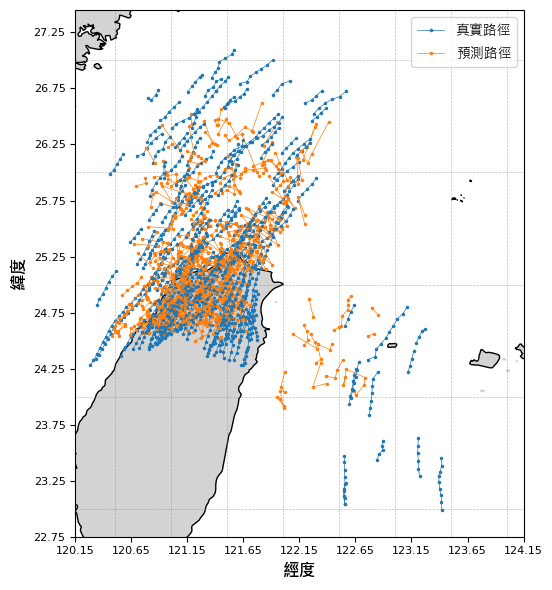

=== 經緯度位置總體評估 ===
Latitude MSE: 0.046096 度
Longitude MSE: 0.024441 度
Latitude MAE: 0.149235 度
Longitude MAE: 0.101835 度
Latitude RMSE: 0.214701
Longitude RMSE: 0.156335
Average Haversine distance error: 20.846155 km



In [69]:
# 測試集資料範圍: 2022-07-01 ~ 2022-08-31 可按照需求調整
# start_date = '2022-10-04'
# end_date = '2022-10-04'
# start_date = '2022-12-06'
# end_date = '2022-12-06'

# 不知道甚麼天氣 要查
# start_date = '2022-11-27'
# end_date = '2022-11-29'
# 東北鋒
# start_date = '2022-05-30'
# end_date = '2022-05-30'
# ===================================
# # 2021-01-16  冬季降雨個案(不太好看)
# start_date = '2021-01-16 06:00:00'
# end_date = '2021-01-16 12:00:00'
# # 2021-05-30  梅雨鋒面個案
# start_date = '2021-05-30 04:00:00'
# end_date = '2021-05-30 10:00:00'
# # 2022-08-25  午後對流個案(很短很小)
# start_date = '2022-08-25 05:00:00'
# end_date = '2022-08-25 11:00:00'
# # 2021-07-22  烟花颱風個案
start_date = '2021-07-22 06:00:00'
end_date = '2021-07-22 12:00:00'
# # 2022-09-04  軒嵐諾颱風
# start_date = '2022-09-04 11:00:00'
# end_date = '2022-09-04 17:00:00'
# ===================================

# 讀取模型
model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})
print('--------------模型讀取成功--------------')

# 讀取資料縮放器
feature_scaler = load_scaler(scaler_path=FEATURE_SCALER_PATH)
label_scaler = load_scaler(scaler_path=LABEL_SCALER_PATH)

# 讀取資料(原始數值資料，LSTM輸入數據，ConvLSTM輸入數據)
dataset_components = read_data(
    start_date=start_date,  
    end_date=end_date,  
    feature_scaler=feature_scaler,
)


dataset, pred_dict, true_dict = predict_path(model, dataset_components, label_scaler)

# 繪製預測路徑與真實路徑
plot_path(dataset, pred_dict)

# 評估模型
distances = evaluate(dataset, pred_dict)
# evaluate(true_dict, pred_dict)

In [62]:
import json

with open('../烟花颱風個案_ffnn_haversine_errors.json', 'w', encoding='utf-8') as f:
    json.dump(distances, f, ensure_ascii=False, indent=2)

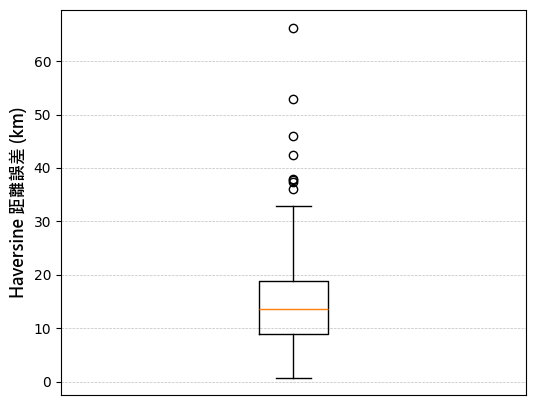

In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.figure(figsize=(6, 5))
plt.boxplot(distances)
# plt.title("FFNN Haversine Distance Error Distribution")
plt.ylabel("Haversine 距離誤差 (km)", fontproperties=jheng_hei_b_font, fontsize=12)
plt.xticks([])
plt.grid(True, axis='y', linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
plt.show()

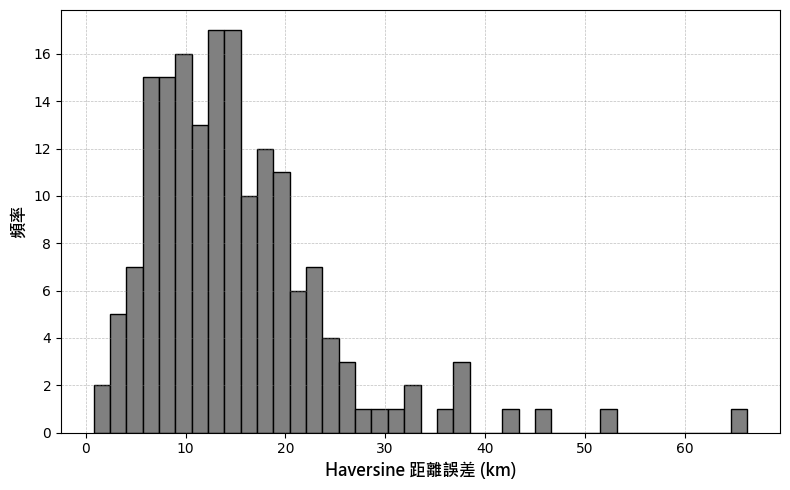

In [52]:
import matplotlib.pyplot as plt

# 假設 haversine_errors 是一個 numpy array 或 list，單位為 km
plt.figure(figsize=(8, 5))
plt.hist(distances, bins=40, color='gray', edgecolor='black')
# plt.title('Haversine Distance Error Histogram')
plt.xlabel('Haversine 距離誤差 (km)', fontproperties=jheng_hei_b_font, fontsize=12)
plt.ylabel('頻率', fontproperties=jheng_hei_b_font, fontsize=12)
plt.grid(True, linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [53]:
import numpy as np
import pandas as pd

# 假設你有這個誤差資料
# haversine_errors = np.array([...])  # 單位為 km

# 自定義誤差區間邊界（可根據需求調整）
bins = [0, 5, 10, 20, 50, 100, np.inf]
labels = ['0–5 km', '5–10 km', '10–20 km', '20–50 km', '50–100 km', '>100 km']

# 分組統計
categories = pd.cut(distances, bins=bins, labels=labels, right=False)
distribution = categories.value_counts().sort_index()
percentages = (distribution / len(distances)) * 100

# 建立結果表格
df = pd.DataFrame({
    '區間': labels,
    '樣本數': distribution.values,
    '比例 (%)': percentages.round(2)
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="誤差分布表（區間分析）", dataframe=df)
df

,區間,樣本數,比例 (%)
0–5 km,0–5 km,12,6.94
5–10 km,5–10 km,42,24.28
10–20 km,10–20 km,82,47.40
20–50 km,20–50 km,35,20.23
50–100 km,50–100 km,2,1.16
>100 km,>100 km,0,0.00


In [54]:
# # ============= 計算誤差(公里) =============
# def calculate_mae_distance(lat_mae: float, lon_mae: float, latitude: float = 25.071182):
#     lat_km = lat_mae * 111
#     lon_km = lon_mae * 111 * math.cos(math.radians(latitude))
#     return math.sqrt(lat_km**2 + lon_km**2)

# # ============= 評估主函式（輸入2預測10，只評估1） =============
# def evaluate(true_dict: dict, pred_dict: dict) -> None:
#     lat_errors = []
#     lng_errors = []
#     distances = []

#     for key in true_dict:
#         true_path = true_dict[key]
#         pred_path = pred_dict.get(key)

#         if pred_path is None:
#             continue

#         # 兩邊長度可能不一致，以最短為準
#         if len(true_path) != len(pred_path):
#             print('長度不同，檢查資料')
#             break

#         for i in range(len(true_path)):
#             true_lat, true_lng = true_path[i]
#             pred_lat, pred_lng = pred_path[i]

#             lat_error = pred_lat - true_lat
#             lng_error = pred_lng - true_lng

#             lat_errors.append(lat_error)
#             lng_errors.append(lng_error)

#             # Haversine distance（公里）
#             distance = haversine((true_lat, true_lng), (pred_lat, pred_lng))
#             distances.append(distance)

#     lat_errors = np.array(lat_errors)
#     lng_errors = np.array(lng_errors)
#     distances = np.array(distances)

#     # === 計算誤差指標 ===
#     lat_mse = np.mean(lat_errors ** 2)
#     lng_mse = np.mean(lng_errors ** 2)
#     lat_rmse = np.sqrt(lat_mse)
#     lng_rmse = np.sqrt(lng_mse)
#     lat_mae = np.mean(np.abs(lat_errors))
#     lng_mae = np.mean(np.abs(lng_errors))
#     avg_haversine = np.mean(distances)

#     print(f"=== 經緯度位置誤差統計（度） ===")
#     print(f"Latitude MSE: {lat_mse:.6f} 度")
#     print(f"Longitude MSE: {lng_mse:.6f} 度")
#     print(f"Latitude MAE: {lat_mae:.6f} 度")
#     print(f"Longitude MAE: {lng_mae:.6f} 度")
#     print(f"Latitude RMSE: {lat_rmse:.6f}")
#     print(f"Longitude RMSE: {lng_rmse:.6f}")
#     print(f"Average Haversine distance error: {avg_haversine:.6f} km")